In [1]:
from analysis import *

drop_cols = [
    "TWD","COG","TWA", "TimeUTC", "SecondsSince1970", "ISODateTimeUTC","Latitude","Longitude","Euler_X (deg)","Euler_Y (deg)",
    "Lat", "LatBow", "LatCenter", "LatStern", "Lon", "LonBow", "LonCenter", "LonStern",
    "Leg", "Log", "LogAlongCourse", "MagneticVariation", "Rank", "TimeLocal",
    "DistanceToLeader", "interval_id", "boat_name", "interval_duration",
    "Heel", "Heel_Lwd", "Line_R", "Line_L", "BelowLineCalc", "VMC","XTE","VMG","gain_forward","gain_lateral", "gain_vmg","Total_lines", "LoadCell_1","LoadCell_2","LoadCell_3","LoadCell_4","LoadCell_5","LoadCell_6","M_tot_X","M_tot_Y","M_front_X","M_front_Y","M_back_X","M_back_Y","P_front_X","P_front_Y","P_back_X","P_back_Y"
]

MAX_NULL_RATIO = 0.2


In [2]:
df = pd.read_csv("all_data_enriched.csv")
df = df[df["boat_name"] == "SenseBoard"].copy()
load_cell_cols = ["LoadCell_1", "LoadCell_2", "LoadCell_3", "LoadCell_4", "LoadCell_5", "LoadCell_6"]
df = df.dropna(subset=load_cell_cols, how='all')
df.sample(10)

,ISODateTimeUTC,SecondsSince1970,Heel_Abs,Heel_Lwd,Lat,LatBow,LatCenter,LatStern,Leg,Line_C,...,M_tot_X,M_tot_Y,M_front_X,M_front_Y,M_back_X,M_back_Y,P_front_X,P_front_Y,P_back_X,P_back_Y
58455,2025-06-10 12:28:34.950000+00:00,1.749559e+09,54.9,54.9,43.535713,43.535711,43.535718,43.535724,NaN,109.358,...,8867.054192,3977.384027,6433.388561,1583.682066,2433.665630,-863.454582,43.525724,-176.814464,-18.099305,-51.013287
20294,2025-06-06 15:09:14.165000+00:00,1.749223e+09,50.0,50.0,43.521103,43.521105,43.521100,43.521096,1.0,91.600,...,-4114.762121,7548.636251,-3379.475745,-909.206682,-735.286376,-741.033867,-59.351093,220.605042,-17.078088,16.945629
59370,2025-06-10 12:29:20.753000+00:00,1.749559e+09,54.2,54.2,43.531303,43.531301,43.531307,43.531313,NaN,109.500,...,6074.381414,6493.073045,3254.867200,-199.897538,2819.514214,-827.364664,-7.525296,-122.531968,-16.413224,-55.933399
49096,2025-06-09 13:05:27.656000+00:00,1.749474e+09,60.0,60.0,43.508267,43.508265,43.508271,43.508277,NaN,8.744,...,10918.449162,758.812703,7275.925622,2051.671330,3642.523540,-1135.932755,51.780433,-183.631058,-26.912373,-86.298200
12323,2025-06-06 14:39:25.060000+00:00,1.749221e+09,59.0,59.0,43.524165,43.524164,43.524168,43.524173,1.0,121.100,...,6016.070256,1555.967954,4550.171529,695.808488,1465.898726,-572.609459,35.830927,-234.312840,-22.842545,-58.477652
31613,2025-06-07 12:47:16.742000+00:00,1.749300e+09,58.1,58.1,43.517542,43.517540,43.517545,43.517550,1.0,9.700,...,7231.413768,579.810263,5684.724215,811.693337,1546.689552,-507.429186,32.890264,-230.348177,-18.520230,-56.451319
55775,2025-06-09 13:28:16.358000+00:00,1.749476e+09,51.9,51.9,43.507335,43.507337,43.507331,43.507325,NaN,3.965,...,-7040.349497,5966.644254,-2836.764523,429.163671,-4203.584975,-1261.552934,19.082949,126.137968,-28.475945,94.883894
64774,2025-06-10 12:47:16.060000+00:00,1.749560e+09,54.8,54.8,43.530326,43.530328,43.530322,43.530316,NaN,108.500,...,-882.682167,2448.530702,-411.420515,-19.345067,-471.261652,-325.068708,-0.591376,12.577060,-7.511882,10.890195
12640,2025-06-06 14:39:40.856000+00:00,1.749221e+09,54.8,54.8,43.523113,43.523112,43.523116,43.523121,1.0,106.024,...,3737.636076,4565.311526,2800.898375,-295.872087,936.737701,-501.174523,-24.849267,-235.237711,-17.666963,-33.021052
17356,2025-06-06 14:58:29.163000+00:00,1.749222e+09,51.0,51.0,43.523470,43.523469,43.523473,43.523478,1.0,84.000,...,6045.217385,4046.324368,4374.292765,167.693621,1670.924621,-534.949553,13.290095,-346.672491,-20.451957,-63.882060


## I. All together

In [3]:
# Select numeric columns
df_numeric = df.select_dtypes(include=["float64", "int64"]).copy()
# Drop specified columns
df_numeric.drop(columns=[c for c in drop_cols if c in df_numeric.columns], inplace=True)

# Drop rows where 'SOG' is missing
df_numeric.dropna(subset=["SOG"], inplace=True)


# Print summary
print(f"Variables utilisées: {df_numeric.columns.tolist()}")
print(f"Number of rows after filtering: {len(df_numeric)}")



Variables utilisées: ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'SOG', 'boat_weight', 'F_front', 'F_back']
Number of rows after filtering: 30546



Initial features (10): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Removed features (> 20% NaN): ['Side_lines']

Selected features (9): ['Heel_Abs', 'Line_C', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 30546
- Removed samples with NaNs: 88
- Final samples: 30458

Correlation with SOG:


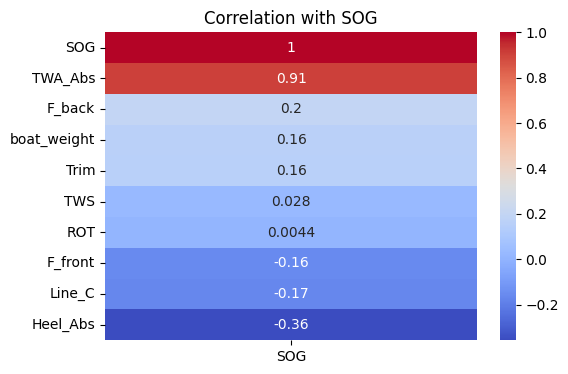


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWA_Abs,85917.355440,1.0,114029.664877,0.000000e+00,0.789255
TWS,2425.798333,1.0,3219.523804,0.000000e+00,0.095627
Trim,1068.028475,1.0,1417.489265,3.032510e-303,0.044484
boat_weight,1051.177461,1.0,1395.124571,1.340071e-298,0.043812
Line_C,605.468467,1.0,803.578812,1.669211e-174,0.025713
F_front,501.236775,1.0,665.242327,3.930109e-145,0.021381
Heel_Abs,303.606797,1.0,402.947474,4.743341e-89,0.013061
F_back,281.184466,1.0,373.188517,1.183591e-82,0.012108
ROT,23.625749,1.0,31.356136,2.166286e-08,0.001029
Residual,22941.500716,30448.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.860
Used features: 9
Polynomial terms generated: 9

Top terms in formula:
2.196 * TWA_Abs
0.375 * TWS
0.224 * boat_weight
-0.198 * Trim
-0.184 * Line_C
0.182 * F_front
0.157 * F_back
0.119 * Heel_Abs
0.028 * ROT


,feature,coefficient
4,TWA_Abs,2.196350
5,TWS,0.374577
6,boat_weight,0.223900
3,Trim,-0.197962
1,Line_C,-0.184429
7,F_front,0.182389
8,F_back,0.156872
0,Heel_Abs,0.119429
2,ROT,0.027917


In [4]:
full_analysis(df_numeric, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

## II Upwind:

### II.1. All upwind data

In [5]:
upwind_data = df[df['TWA'] >= 0]
df_numeric_upwind = upwind_data.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_upwind.columns], inplace=True)
df_numeric_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_upwind)}")

Number of rows after filtering: 18876


In [6]:
print(upwind_data['boat_name'].unique())
print(upwind_data['opponent_name'].unique())
print(upwind_data['TWA'].mean())

['SenseBoard']
['Karl Maeder' 'Gian Stragiotti']
48.36674316592499



Initial features (10): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Removed features (> 20% NaN): ['Side_lines']

Selected features (9): ['Heel_Abs', 'Line_C', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 18876
- Removed samples with NaNs: 59
- Final samples: 18817

Correlation with SOG:


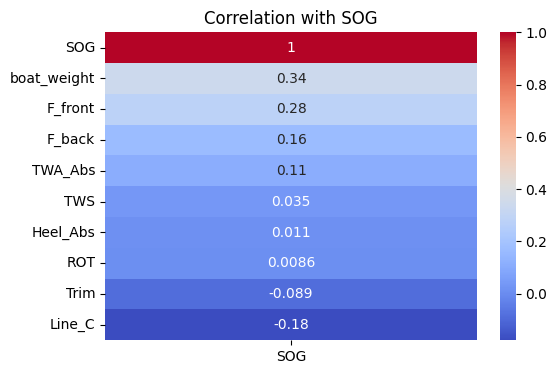


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
F_front,1033.307995,1.0,1904.423640,0.000000e+00,0.091950
boat_weight,826.529744,1.0,1523.323919,1.802846e-320,0.074929
TWS,628.145097,1.0,1157.693910,2.669909e-246,0.057987
Line_C,508.579440,1.0,937.330121,6.267481e-201,0.047473
Trim,300.244930,1.0,553.362159,1.284438e-120,0.028582
TWA_Abs,186.369609,1.0,343.485863,5.279398e-76,0.017936
F_back,75.413795,1.0,138.990325,5.735672e-32,0.007336
ROT,27.440295,1.0,50.573445,1.189084e-12,0.002682
Heel_Abs,3.884225,1.0,7.158767,7.466306e-03,0.000380
Residual,10204.359497,18807.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.294
Used features: 9
Polynomial terms generated: 9

Top terms in formula:
0.321 * F_front
0.258 * TWS
0.236 * boat_weight
-0.209 * Line_C
-0.128 * Trim
0.119 * TWA_Abs
0.105 * F_back
0.039 * ROT
-0.015 * Heel_Abs


,feature,coefficient
7,F_front,0.321060
5,TWS,0.258492
6,boat_weight,0.235569
1,Line_C,-0.208923
3,Trim,-0.128270
4,TWA_Abs,0.119134
8,F_back,0.105268
2,ROT,0.039073
0,Heel_Abs,-0.015086


In [7]:
full_analysis(df_numeric_upwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

### II.2. Upwind: Gian vs Karl
#### II.2.1. Upwind: Gian

In [8]:
gian_data_upwind = upwind_data[((upwind_data['boat_name'] == "SenseBoard") & (upwind_data['opponent_name'] == "Karl Maeder"))]
df_numeric_gian_upwind = gian_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_gian_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_gian_upwind.columns], inplace=True)
df_numeric_gian_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_gian_upwind)}")

Number of rows after filtering: 13275


In [9]:
print(gian_data_upwind['boat_name'].unique())
print(gian_data_upwind['opponent_name'].unique())
print(gian_data_upwind['TWA'].mean())

['SenseBoard']
['Karl Maeder']
48.03460655367232



Initial features (10): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Selected features (10): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 13275
- Removed samples with NaNs: 42
- Final samples: 13233

Correlation with SOG:


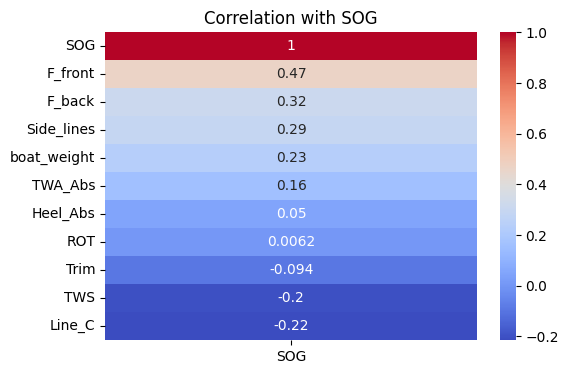


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
F_front,745.352709,1.0,1412.437003,8.775914e-294,0.096515
TWS,275.919193,1.0,522.864509,1.582006e-113,0.038041
Trim,161.972730,1.0,306.936938,5.933708e-68,0.022687
Side_lines,101.922591,1.0,193.142438,1.327238e-43,0.014397
TWA_Abs,64.713004,1.0,122.630589,2.238728e-28,0.009190
F_back,36.586519,1.0,69.331140,9.137337e-17,0.005216
Heel_Abs,23.480768,1.0,44.495855,2.650378e-11,0.003354
ROT,11.204361,1.0,21.232167,4.106812e-06,0.001603
Line_C,1.860791,1.0,3.526183,6.042871e-02,0.000267
boat_weight,0.355136,1.0,0.672980,4.120292e-01,0.000051



Polynomial fit:

Model performance:
R²: 0.321
Used features: 10
Polynomial terms generated: 10

Top terms in formula:
0.385 * Side_lines
0.372 * F_front
0.218 * TWS
-0.112 * Trim
0.093 * F_back
0.082 * TWA_Abs
0.050 * Line_C
-0.045 * Heel_Abs
0.030 * ROT
0.007 * boat_weight


,feature,coefficient
3,Side_lines,0.384715
8,F_front,0.371517
6,TWS,0.217549
4,Trim,-0.111691
9,F_back,0.093087
5,TWA_Abs,0.082455
1,Line_C,0.050125
0,Heel_Abs,-0.045306
2,ROT,0.029856
7,boat_weight,0.007225


In [10]:
full_analysis(df_numeric_gian_upwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### II.2.2. Upwind: Karl

In [11]:
karl_data_upwind = upwind_data[((upwind_data['boat_name'] == "SenseBoard") & (upwind_data['opponent_name'] == "Gian Stragiotti"))]
df_numeric_karl_upwind = karl_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_karl_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_karl_upwind.columns], inplace=True)
df_numeric_karl_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_karl_upwind)}")
print(df_numeric_karl_upwind.shape)
print(df_numeric_karl_upwind.columns)

Number of rows after filtering: 5601
(5601, 11)
Index(['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS',
       'SOG', 'boat_weight', 'F_front', 'F_back'],
      dtype='object')


In [12]:
print(karl_data_upwind['boat_name'].unique())
print(karl_data_upwind['opponent_name'].unique())
print(karl_data_upwind['TWA'].mean())

['SenseBoard']
['Gian Stragiotti']
49.153944295661496


In [13]:
df_numeric_karl_upwind.head(10)

,Heel_Abs,Line_C,ROT,Side_lines,Trim,TWA_Abs,TWS,SOG,boat_weight,F_front,F_back
25553,59.5,93.3,11.000,NaN,7.5,41.174,9.352,21.4,102.89,27567.598622,24661.188272
25555,57.4,88.1,-14.141,NaN,12.3,42.564,9.372,21.4,102.89,30282.257552,24532.446152
25557,59.8,98.4,1.020,NaN,8.7,42.454,9.391,21.3,102.89,30629.872010,26538.607253
25560,57.8,108.1,15.000,NaN,1.5,40.944,9.411,21.4,102.89,29534.445709,25671.679650
25562,53.0,111.4,-7.619,NaN,4.6,41.734,9.432,21.4,102.89,31969.060202,27080.840797
25563,54.8,111.3,-10.309,NaN,7.0,42.724,9.452,21.4,102.89,32674.719191,26459.098753
25565,54.6,110.7,11.224,NaN,7.0,41.614,9.471,21.3,102.89,34743.378192,26875.356725
25567,47.0,109.9,-19.802,NaN,6.2,43.604,9.492,21.4,102.89,34743.378192,26875.356725
25569,41.2,107.5,7.000,NaN,4.4,42.894,9.506,21.3,102.89,30655.266332,26253.937186
25571,51.7,104.6,1.000,NaN,8.5,42.784,9.516,21.4,102.89,30655.266332,26253.937186



Initial features (10): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Removed features (> 20% NaN): ['Side_lines']

Selected features (9): ['Heel_Abs', 'Line_C', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 5601
- Removed samples with NaNs: 17
- Final samples: 5584

Correlation with SOG:


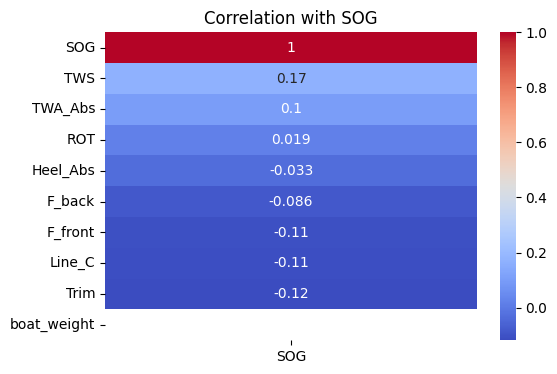


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,4598.244751,1.0,9685.361760,0.000000e+00,0.634674
TWA_Abs,246.517194,1.0,519.243393,5.706783e-110,0.085202
TWS,195.231855,1.0,411.220205,2.842816e-88,0.068694
Trim,93.653566,1.0,197.264112,4.622077e-44,0.034174
F_back,15.631601,1.0,32.925110,1.008229e-08,0.005871
ROT,12.608568,1.0,26.557643,2.646028e-07,0.004741
Heel_Abs,9.943821,1.0,20.944841,4.829555e-06,0.003743
Line_C,5.844075,1.0,12.309476,4.542211e-04,0.002203
F_front,2.640326,1.0,5.561364,1.839543e-02,0.000997
Residual,2646.799895,5575.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.135
Used features: 9
Polynomial terms generated: 9

Top terms in formula:
0.336 * TWS
0.274 * TWA_Abs
-0.136 * Trim
0.086 * F_back
0.049 * ROT
0.046 * Heel_Abs
-0.045 * Line_C
-0.029 * F_front
0.000 * boat_weight


,feature,coefficient
5,TWS,3.358031e-01
4,TWA_Abs,2.736814e-01
3,Trim,-1.357438e-01
8,F_back,8.641826e-02
2,ROT,4.868985e-02
0,Heel_Abs,4.570711e-02
1,Line_C,-4.452198e-02
7,F_front,-2.866813e-02
6,boat_weight,5.551115e-17


In [14]:
full_analysis(df_numeric_karl_upwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### II.2.3. Upwind: Karl vs Gian t_test

In [15]:
t_test(df_numeric_gian_upwind,df_numeric_karl_upwind)

T-statistic: 39.897, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


### II.3. Upwind: Master vs Slave
#### II.3.1. Master

In [16]:
master_data_upwind = upwind_data[upwind_data['boat_role'] == "master"]
df_numeric_master_upwind = master_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_master_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_master_upwind.columns], inplace=True)
df_numeric_master_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_master_upwind)}")

Number of rows after filtering: 9638



Initial features (10): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Removed features (> 20% NaN): ['Side_lines']

Selected features (9): ['Heel_Abs', 'Line_C', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 9638
- Removed samples with NaNs: 35
- Final samples: 9603

Correlation with SOG:


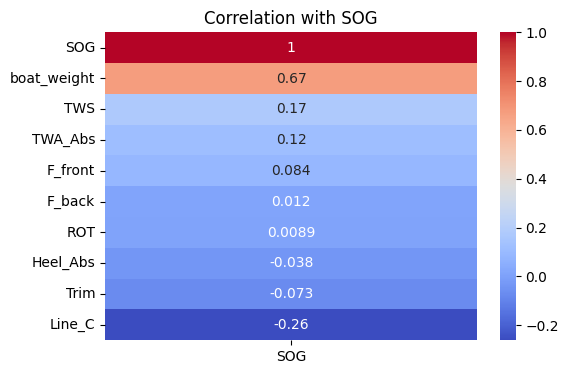


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,1663.949188,1.0,4258.827652,0.000000e+00,0.307456
F_front,293.900530,1.0,752.229523,1.671198e-159,0.072713
TWS,102.286085,1.0,261.798143,4.076530e-58,0.026566
Trim,84.931725,1.0,217.380183,1.147045e-48,0.022158
Line_C,80.427799,1.0,205.852519,3.312997e-46,0.021008
F_back,14.198949,1.0,36.341781,1.716799e-09,0.003774
Heel_Abs,9.342762,1.0,23.912516,1.024507e-06,0.002487
TWA_Abs,8.063948,1.0,20.639432,5.611962e-06,0.002147
ROT,1.534072,1.0,3.926410,4.756181e-02,0.000409
Residual,3748.041918,9593.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.517
Used features: 9
Polynomial terms generated: 9

Top terms in formula:
0.562 * boat_weight
0.247 * F_front
0.175 * TWS
-0.120 * Line_C
-0.096 * Trim
0.058 * F_back
-0.040 * TWA_Abs
-0.033 * Heel_Abs
0.013 * ROT


,feature,coefficient
6,boat_weight,0.562431
7,F_front,0.247238
5,TWS,0.175363
1,Line_C,-0.120431
3,Trim,-0.096132
8,F_back,0.058383
4,TWA_Abs,-0.040387
0,Heel_Abs,-0.032821
2,ROT,0.013050


In [17]:
full_analysis(df_numeric_master_upwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### II.3.2 Slave

In [18]:
slave_data_upwind = upwind_data[upwind_data['boat_role'] == "slave"]
df_numeric_slave_upwind = slave_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_slave_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_slave_upwind.columns], inplace=True)
df_numeric_slave_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_slave_upwind)}")

Number of rows after filtering: 9238



Initial features (10): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Removed features (> 20% NaN): ['Side_lines']

Selected features (9): ['Heel_Abs', 'Line_C', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 9238
- Removed samples with NaNs: 24
- Final samples: 9214

Correlation with SOG:


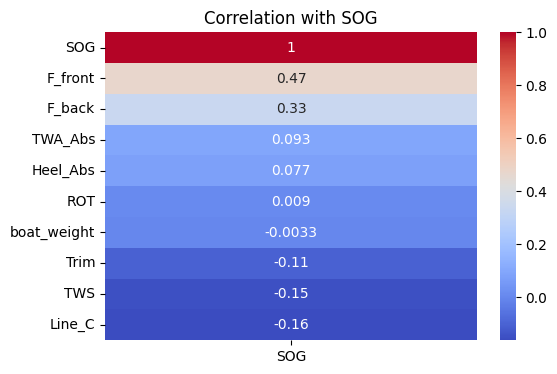


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
Line_C,316.085912,1.0,665.165387,1.113780e-141,0.067398
F_front,301.877511,1.0,635.265488,1.319389e-135,0.064564
Trim,123.580019,1.0,260.059522,1.024856e-57,0.027479
F_back,114.923175,1.0,241.842218,7.528963e-54,0.025603
TWS,58.819481,1.0,123.778634,1.432211e-28,0.013270
Heel_Abs,3.968254,1.0,8.350720,3.864350e-03,0.000906
ROT,3.399044,1.0,7.152886,7.497569e-03,0.000777
boat_weight,3.259619,1.0,6.859483,8.831662e-03,0.000745
TWA_Abs,1.895927,1.0,3.989755,4.580711e-02,0.000433
Residual,4373.731399,9204.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.296
Used features: 9
Polynomial terms generated: 9

Top terms in formula:
0.278 * F_front
-0.254 * Line_C
0.222 * F_back
-0.118 * Trim
0.112 * TWS
-0.022 * Heel_Abs
-0.021 * boat_weight
0.020 * ROT
0.017 * TWA_Abs


,feature,coefficient
7,F_front,0.278038
1,Line_C,-0.253922
8,F_back,0.222191
3,Trim,-0.117812
5,TWS,0.111781
0,Heel_Abs,-0.021975
6,boat_weight,-0.021219
2,ROT,0.019657
4,TWA_Abs,0.017472


In [19]:
full_analysis(df_numeric_slave_upwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### III.3.3. Upwind: Master vs Slave t_test

In [20]:
t_test(df_numeric_master_upwind,df_numeric_slave_upwind)

T-statistic: 25.880, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


## III Downwind
### III.1. All downwind data

In [21]:
downwind_data = df[df['TWA'] < 0]
df_numeric_downwind = downwind_data.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_downwind.columns], inplace=True)
df_numeric_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_downwind)}")

Number of rows after filtering: 11670


In [22]:
print(downwind_data['boat_name'].unique())
print(downwind_data['opponent_name'].unique())
print(downwind_data['TWA'].mean())

['SenseBoard']
['Karl Maeder' 'Gian Stragiotti']
-141.4931527849186



Initial features (10): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Removed features (> 20% NaN): ['Side_lines']

Selected features (9): ['Heel_Abs', 'Line_C', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 11670
- Removed samples with NaNs: 29
- Final samples: 11641

Correlation with SOG:


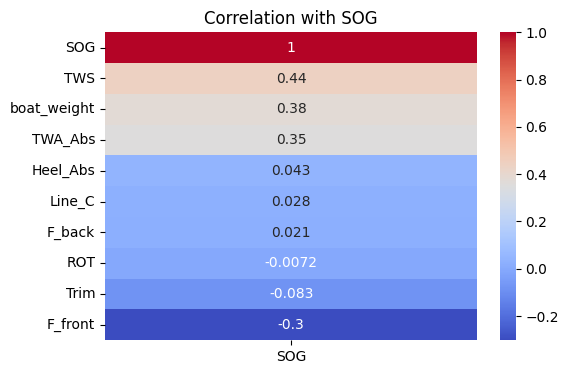


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWS,1199.877014,1.0,1352.724671,3.035780e-280,0.104186
Trim,718.803628,1.0,810.369221,2.247888e-172,0.065135
Heel_Abs,694.224439,1.0,782.658985,9.780724e-167,0.063048
F_back,265.166014,1.0,298.944479,3.744959e-66,0.025058
boat_weight,250.331600,1.0,282.220367,1.344733e-62,0.023690
F_front,188.425123,1.0,212.427865,1.067310e-47,0.017936
TWA_Abs,165.495101,1.0,186.576877,3.754286e-42,0.015788
ROT,24.654495,1.0,27.795135,1.372809e-07,0.002384
Line_C,14.985044,1.0,16.893931,3.979906e-05,0.001450
Residual,10316.784969,11631.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.380
Used features: 9
Polynomial terms generated: 9

Top terms in formula:
0.477 * TWS
0.297 * Heel_Abs
-0.274 * Trim
0.257 * F_back
0.224 * boat_weight
-0.204 * F_front
0.164 * TWA_Abs
-0.052 * Line_C
-0.048 * ROT


,feature,coefficient
5,TWS,0.477148
0,Heel_Abs,0.297390
3,Trim,-0.273941
8,F_back,0.257420
6,boat_weight,0.224287
7,F_front,-0.204169
4,TWA_Abs,0.163788
1,Line_C,-0.052188
2,ROT,-0.047958


In [23]:

full_analysis(df_numeric_downwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

### III.2. Downwind: Gian vs Karl
#### III.2.1. Downwind: Gian

In [24]:
gian_data_downwind = downwind_data[((downwind_data['boat_name'] == "SenseBoard") & (downwind_data['opponent_name'] == "Karl Maeder"))]
df_numeric_gian_downwind = gian_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_gian_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_gian_downwind.columns], inplace=True)
df_numeric_gian_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_gian_downwind)}")

Number of rows after filtering: 7826


In [25]:
print(gian_data_downwind['boat_name'].unique())
print(gian_data_downwind['opponent_name'].unique())
print(gian_data_downwind['TWA'].mean())

['SenseBoard']
['Karl Maeder']
-144.02090429338105



Initial features (10): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Selected features (10): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 7826
- Removed samples with NaNs: 23
- Final samples: 7803

Correlation with SOG:


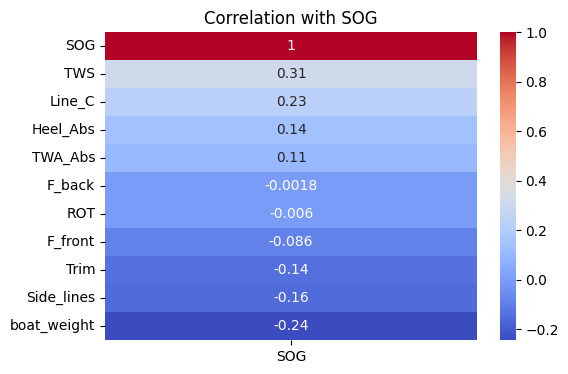


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWS,962.827764,1.0,1191.018987,5.314048e-243,0.132586
Side_lines,379.737135,1.0,469.735247,3.407176e-101,0.056857
boat_weight,209.666280,1.0,259.357416,1.989188e-57,0.032213
Line_C,144.803508,1.0,179.122096,2.100678e-40,0.022471
Trim,133.760353,1.0,165.461702,1.742471e-37,0.020793
Heel_Abs,129.867362,1.0,160.646067,1.869130e-36,0.020200
TWA_Abs,74.036677,1.0,91.583450,1.405424e-21,0.011617
F_back,36.755196,1.0,45.466217,1.663794e-11,0.005801
F_front,33.688069,1.0,41.672178,1.143975e-10,0.005320
ROT,1.926524,1.0,2.383113,1.226936e-01,0.000306



Polynomial fit:

Model performance:
R²: 0.262
Used features: 10
Polynomial terms generated: 10

Top terms in formula:
0.828 * Side_lines
0.503 * Line_C
0.498 * TWS
-0.264 * boat_weight
0.174 * Heel_Abs
-0.158 * Trim
0.124 * TWA_Abs
0.112 * F_back
-0.100 * F_front
-0.016 * ROT


,feature,coefficient
3,Side_lines,0.827594
1,Line_C,0.503088
6,TWS,0.497873
7,boat_weight,-0.264347
0,Heel_Abs,0.173604
4,Trim,-0.158352
5,TWA_Abs,0.124349
9,F_back,0.111924
8,F_front,-0.100203
2,ROT,-0.016486


In [26]:

full_analysis(df_numeric_gian_downwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### III.2.2. Downwind: Karl

In [27]:
karl_data_downwind = downwind_data[
    (downwind_data['boat_name'] == "Karl Maeder") |
    ((downwind_data['boat_name'] == "SenseBoard") & (downwind_data['opponent_name'] == "Gian Stragiotti"))
]
df_numeric_karl_downwind = karl_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_karl_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_karl_downwind.columns], inplace=True)
df_numeric_karl_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_karl_downwind)}")

Number of rows after filtering: 3844


In [28]:
print(karl_data_downwind['boat_name'].unique())
print(karl_data_downwind['opponent_name'].unique())
print(karl_data_downwind['TWA'].mean())

['SenseBoard']
['Gian Stragiotti']
-136.34690322580647



Initial features (10): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Removed features (> 20% NaN): ['Side_lines']

Selected features (9): ['Heel_Abs', 'Line_C', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 3844
- Removed samples with NaNs: 6
- Final samples: 3838

Correlation with SOG:


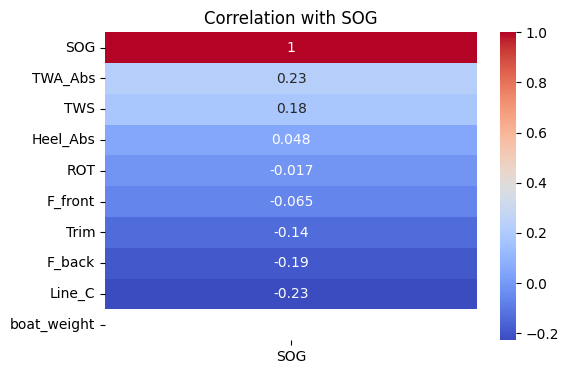


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,1978.470978,1.0,3024.729178,0.000000e+00,0.441326
Trim,292.014819,1.0,446.438565,8.025132e-94,0.104419
Heel_Abs,177.459225,1.0,271.303498,6.013933e-59,0.066167
Line_C,161.363777,1.0,246.696429,6.355927e-54,0.060529
F_front,133.389888,1.0,203.929342,4.098325e-45,0.050566
TWA_Abs,55.567557,1.0,84.952882,4.914748e-20,0.021705
F_back,16.445748,1.0,25.142614,5.565583e-07,0.006524
TWS,11.771670,1.0,17.996784,2.265131e-05,0.004678
ROT,6.755128,1.0,10.327385,1.321582e-03,0.002690
Residual,2504.543358,3829.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.230
Used features: 9
Polynomial terms generated: 9

Top terms in formula:
0.462 * F_front
-0.332 * Line_C
-0.325 * Trim
0.258 * Heel_Abs
-0.231 * F_back
0.204 * TWA_Abs
0.090 * TWS
-0.045 * ROT
0.000 * boat_weight


,feature,coefficient
7,F_front,4.622215e-01
1,Line_C,-3.324574e-01
3,Trim,-3.247854e-01
0,Heel_Abs,2.577719e-01
8,F_back,-2.305324e-01
4,TWA_Abs,2.043650e-01
5,TWS,9.002057e-02
2,ROT,-4.452262e-02
6,boat_weight,3.330669e-16


In [29]:
full_analysis(df_numeric_karl_downwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### III.2.3. Downwind: Karl vs Gian t_test

In [30]:
t_test(df_numeric_karl_downwind,df_numeric_gian_downwind)

T-statistic: -69.413, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


### III.3. Downwind: Master vs Slave
#### III.3.1 Downwind Master

In [31]:
master_data_downwind = downwind_data[downwind_data['boat_role'] == "master"]
df_numeric_master_downwind = master_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_master_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_master_downwind.columns], inplace=True)
df_numeric_master_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_master_downwind)}")

Number of rows after filtering: 6136



Initial features (10): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Removed features (> 20% NaN): ['Side_lines']

Selected features (9): ['Heel_Abs', 'Line_C', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 6136
- Removed samples with NaNs: 14
- Final samples: 6122

Correlation with SOG:


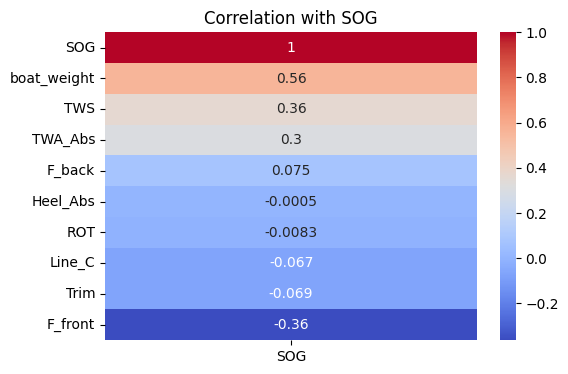


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,374.832621,1.0,552.047469,6.048591e-117,0.082840
Trim,158.992328,1.0,234.161349,6.696481e-52,0.036898
Heel_Abs,120.800570,1.0,177.913142,4.999206e-40,0.028285
F_front,116.727860,1.0,171.914919,9.382485e-39,0.027358
TWS,104.259479,1.0,153.551688,7.586321e-35,0.024507
F_back,65.496541,1.0,96.462254,1.336031e-22,0.015537
TWA_Abs,55.701822,1.0,82.036750,1.766496e-19,0.013244
Line_C,6.203606,1.0,9.136571,2.515889e-03,0.001493
ROT,5.649149,1.0,8.319977,3.934848e-03,0.001359
Residual,4149.963741,6112.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.428
Used features: 9
Polynomial terms generated: 9

Top terms in formula:
0.436 * boat_weight
-0.221 * F_front
0.219 * TWS
0.193 * F_back
-0.181 * Trim
0.175 * Heel_Abs
0.128 * TWA_Abs
0.050 * Line_C
-0.032 * ROT


,feature,coefficient
6,boat_weight,0.435562
7,F_front,-0.221161
5,TWS,0.219305
8,F_back,0.192727
3,Trim,-0.181406
0,Heel_Abs,0.175199
4,TWA_Abs,0.127913
1,Line_C,0.050227
2,ROT,-0.031773


In [32]:
full_analysis(df_numeric_master_downwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### III.3.2 Downwind Slave

In [33]:
slave_data_downwind = downwind_data[downwind_data['boat_role'] == "slave"]
df_numeric_slave_downwind = slave_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_slave_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_slave_downwind.columns], inplace=True)
df_numeric_slave_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_slave_downwind)}")

Number of rows after filtering: 5534



Initial features (10): ['Heel_Abs', 'Line_C', 'ROT', 'Side_lines', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Removed features (> 20% NaN): ['Side_lines']

Selected features (9): ['Heel_Abs', 'Line_C', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 5534
- Removed samples with NaNs: 15
- Final samples: 5519

Correlation with SOG:


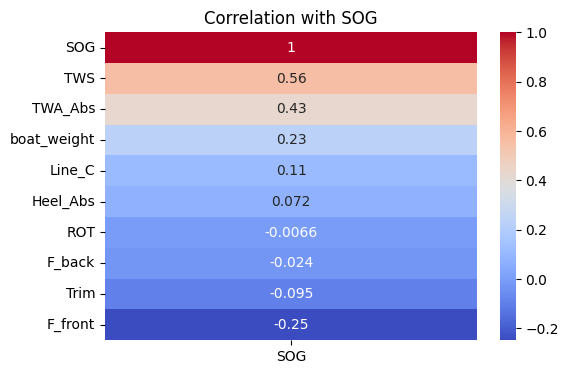


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWS,1317.694542,1.0,1430.503759,1.658946e-278,0.206139
Trim,504.082651,1.0,547.237698,1.818183e-115,0.090359
Heel_Abs,427.569228,1.0,464.173880,6.502219e-99,0.077710
TWA_Abs,268.153095,1.0,291.109964,1.200765e-63,0.050190
F_back,78.231774,1.0,84.929279,4.308219e-20,0.015182
boat_weight,34.970957,1.0,37.964858,7.713786e-10,0.006844
Line_C,33.200114,1.0,36.042410,2.054019e-09,0.006500
ROT,21.115097,1.0,22.922783,1.730525e-06,0.004144
F_front,0.326415,1.0,0.354359,5.516802e-01,0.000064
Residual,5074.561453,5509.0,NaN,NaN,0.500000



Polynomial fit:

Model performance:
R²: 0.453
Used features: 9
Polynomial terms generated: 9

Top terms in formula:
0.686 * TWS
0.336 * Heel_Abs
0.333 * TWA_Abs
-0.332 * Trim
0.193 * F_back
0.113 * boat_weight
-0.108 * Line_C
-0.064 * ROT
0.013 * F_front


,feature,coefficient
5,TWS,0.686121
0,Heel_Abs,0.336218
4,TWA_Abs,0.333451
3,Trim,-0.331972
8,F_back,0.193027
6,boat_weight,0.113443
1,Line_C,-0.107567
2,ROT,-0.064383
7,F_front,0.012988


In [34]:
full_analysis(df_numeric_slave_downwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### III.3.3. Downwind: Master vs Slave t_test

In [35]:
t_test(df_numeric_master_downwind,df_numeric_slave_downwind)

T-statistic: 9.267, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.
